## Heston Model: Closed Form & FFT

#### Cristobal Gonzalez
#### Deniz Kural
#### Liam Trodden

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
import time
from scipy.stats import norm

#### Data Analysis

In [2]:
df = pd.read_excel('/Users/cgonzalezcorssen/Desktop/NYU/Courses/S1 Quantitative Methods 6083/Project/Code/S&P 500 INDEX 3.xlsx', 
                   index_col = 0)
#df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,Maturity,Strike,Lowest Closing Ask Across All Exchanges,Implied Volatility of the Option,Vega/Kappa of the Option,Rate,Spot
The Date of this Price,,,,,,,
01/16/2018,94,1200,1575.6,0.612367,9.031871,1.45,2776.419922
01/16/2018,94,1350,1426.5,0.551055,13.246970,1.45,2776.419922
01/16/2018,94,1400,1376.8,0.530554,14.793470,1.45,2776.419922
01/16/2018,94,1450,1327.3,0.521513,18.835150,1.45,2776.419922
01/16/2018,94,1500,1277.4,0.492622,18.771730,1.45,2776.419922


In [3]:
print(df.columns)
print(df.shape)

Index(['Maturity', 'Strike', 'Lowest  Closing Ask Across All Exchanges',
       'Implied Volatility of the Option', 'Vega/Kappa of the Option', 'Rate',
       'Spot'],
      dtype='object')
(8963, 7)


In [4]:
df.index = pd.to_datetime(df.index)
df.head()

,Maturity,Strike,Lowest Closing Ask Across All Exchanges,Implied Volatility of the Option,Vega/Kappa of the Option,Rate,Spot
The Date of this Price,,,,,,,
2018-01-16,94,1200,1575.6,0.612367,9.031871,1.45,2776.419922
2018-01-16,94,1350,1426.5,0.551055,13.246970,1.45,2776.419922
2018-01-16,94,1400,1376.8,0.530554,14.793470,1.45,2776.419922
2018-01-16,94,1450,1327.3,0.521513,18.835150,1.45,2776.419922
2018-01-16,94,1500,1277.4,0.492622,18.771730,1.45,2776.419922


In [5]:
Quarter1 = pd.to_datetime("2018-03-31")
Quarter2 = pd.to_datetime("2018-06-30")
Quarter3 = pd.to_datetime("2018-09-30")

DataQ1 = df[df.index <= Quarter1].copy()
DataQ2 = df[(df.index >= Quarter1) & (df.index <= Quarter2)].copy()
DataQ3 = df[(df.index >= Quarter2) & (df.index <= Quarter3)].copy()
DataQ4 = df[df.index >= Quarter3].copy()

#### Functions Heston Closed Form

In [6]:
def HestonCF(phi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2):
    
    xx = np.log(Spot)
    
    rvpj = rho * volvol * phi * 1j
    
    uu = np.array([0.5, -0.5])[P1P2-1]
    
    aa = kappa * theta
    
    bb = np.array([kappa - rho * volvol, kappa])[P1P2-1]
    
    ddaux = np.power(rvpj - bb, 2) - np.power(volvol, 2) * (2 * uu * phi * 1j - np.power(phi, 2))

    dd = np.power(ddaux, 0.5)
    
    gg = (bb - rvpj + dd) / (bb - rvpj - dd)
    
    DDaux = (1 - np.exp(dd * Maturity)) / (1 - gg * np.exp(dd * Maturity))
    DD = ((bb - rvpj + dd) / np.power(volvol, 2)) * DDaux
    
    CCaux = (bb - rvpj + dd) * Maturity - 2 * np.log((1 - gg * np.exp(dd * Maturity)) / (1 - gg))
    CC = (rate - div) * phi * Maturity * 1j + (aa / np.power(volvol, 2)) * CCaux
    
    CF1 = np.exp(CC + DD * var0 + xx * phi * 1j)
    
    return CF1

In [7]:
def IntFuncHeston(phi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2, Strike):
    
    CF1 = HestonCF(phi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2)
    
    Output = np.real((np.exp(-phi * np.log(Strike) * 1j) * CF1) / (phi * 1j))
    
    return Output

In [8]:
def NUM_INTEGRATION_HESTON(Function, aLim, bLim, nDiv, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2, Strike):
    # nDiv must be even
    Delta  = (bLim - aLim) / nDiv
    
    EveryX = np.linspace(aLim, bLim, nDiv + 1)
    
    EveryY = Function(EveryX, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2, Strike)
    
    Integral = Delta/3 * np.sum(EveryY[0:-1:2] + 4*EveryY[1::2] + EveryY[2::2])
    
    return Integral

In [9]:
def P1P2Heston(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2, Strike):
    
    NumInt = NUM_INTEGRATION_HESTON(IntFuncHeston, 0.0001, 200, 500, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2, Strike)
    
    PP = 0.5 + (1 / np.pi) * NumInt
    
    return PP
    

In [10]:
def CallHestonCForm(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, Strike):
    
    P1 = P1P2Heston(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, 1, Strike)
    P2 = P1P2Heston(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, 2, Strike)
    
    CallValue = Spot * np.exp(-div * Maturity) * P1 - Strike * np.exp(-rate * Maturity) * P2
    
    return CallValue

In [11]:
Spot = 100
Maturity = 1
kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014
rate = 0.02
div = 0.005
P1P2 = 1 # enter 1 for P1 or 2 for P2
Strike = 101

print(P1P2Heston(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, P1P2, Strike))
print(CallHestonCForm(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, Strike))

0.6204244222912008
5.1570278422607245


#### Calibration Heston Closed Form

In [23]:
def OptFunctionClosedF(Params, Spots, Maturities, Rates, Strikes, MarketP, MarketVega):
    
    kappa = np.exp(Params[0])
    rho = np.arctanh(Params[1])
    volvol = np.exp(Params[2])
    theta = np.exp(Params[3])
    var0 = np.exp(Params[4])
    
    ModelRes = np.zeros(len(Spots))
    
    for i in range(0, len(Spots)):
        ModelRes[i] = CallHestonCForm(Spots[i], Maturities[i], kappa, rho, volvol, theta, var0, Rates[i], 0, Strikes[i])
    
    Error = np.sum(np.power((ModelRes - MarketP), 2))
    #Error = np.sum(np.power((ModelRes - MarketP) / MarketVega, 2))
    
    return Error / len(Spots)

In [ ]:
DataCalib = df[df.index <= pd.to_datetime('2018-01-31')].copy()

Maturities = np.array(DataCalib['Maturity']) / 365
Strikes = np.array(DataCalib['Strike'])
MarketP = np.array(DataCalib['Lowest  Closing Ask Across All Exchanges'])
MarketVol = np.array(DataCalib['Implied Volatility of the Option'])
MarketVega= np.array(DataCalib['Vega/Kappa of the Option'])
Rates = np.array(DataCalib['Rate']) / 100
Spots = np.array(DataCalib['Spot'])

kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014

Params0 = np.array([kappa, rho, volvol, theta, var0])
start = time.time()
result = minimize(OptFunction, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
#bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

#result = minimize(OptFunctionClosedF, Params0, method="SLSQP", bounds = bnds,
#                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

end = time.time()
print(end - start)
result

In [24]:
DataCalib = df[df.index <= pd.to_datetime('2018-01-31')].copy()

Maturities = np.array(DataCalib['Maturity']) / 365
Strikes = np.array(DataCalib['Strike'])
MarketP = np.array(DataCalib['Lowest  Closing Ask Across All Exchanges'])
MarketVol = np.array(DataCalib['Implied Volatility of the Option'])
MarketVega= np.array(DataCalib['Vega/Kappa of the Option'])
Rates = np.array(DataCalib['Rate']) / 100
Spots = np.array(DataCalib['Spot'])

kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014


kappaY = np.log(kappa)
rhoY = np.tanh(rho)
volvolY = np.log(volvol)
thetaY = np.log(theta)
var0Y = np.log(var0)


Params0 = np.array([kappaY, rhoY, volvolY, thetaY, var0Y])
start = time.time()

result = minimize(OptFunctionClosedF, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

#bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

#result = minimize(OptFunctionClosedF, Params0, method="SLSQP", bounds = bnds,
#                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

end = time.time()
print(end - start)
result

548.449805021286


 final_simplex: (array([[  2.51992515,  -0.5836736 ,  -0.14130401, -10.79845916,
         -3.05198299],
       [  2.51990121,  -0.58368196,  -0.1413393 , -10.79893976,
         -3.05200252],
       [  2.51993083,  -0.58367709,  -0.14132382, -10.79864598,
         -3.05198067],
       [  2.51990008,  -0.58367753,  -0.14133606, -10.79847351,
         -3.05200544],
       [  2.51990617,  -0.58367491,  -0.14133545, -10.79858368,
         -3.05199915],
       [  2.51987796,  -0.5836833 ,  -0.14136225, -10.79861925,
         -3.05202599]]), array([11.09045009, 11.09045039, 11.09045112, 11.09048549, 11.0904856 ,
       11.09048564]))
           fun: 11.090450091463609
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1006
           nit: 616
        status: 1
       success: False
             x: array([  2.51992515,  -0.5836736 ,  -0.14130401, -10.79845916,
        -3.05198299])

#### Functions FFT Heston

In [25]:
def HestonCfFFT(phi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div):
    
    xx = np.log(Spot)
    
    gamma = kappa - rho * volvol * phi * 1j
    
    zeta = - 0.5 * (np.power(phi, 2) + 1j * phi)
    
    psi = np.power(np.power(gamma,2) - 2 * np.power(volvol,2) * zeta, 0.5)
    
    CCaux = (2 * psi - (psi - gamma) * (1 - np.exp(-psi * Maturity))) / (2 * psi)
    CC = (-(kappa * theta) / np.power(volvol, 2)) * (2 * np.log(CCaux) + (psi - gamma) * Maturity)
    
    BB = (2 * zeta * (1 - np.exp(-psi * Maturity)) * var0) / (2 * psi - (psi - gamma) * (1 - np.exp(-psi * Maturity)))
    
    AA = 1j * phi * (xx + rate * Maturity)
    
    return np.exp(AA + BB + CC)

In [26]:
def HestonModCfFFT(phi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, alpha):
    
    NewPhi = phi - (alpha + 1)* 1j
    
    CF = HestonCfFFT(NewPhi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div)
    
    NumCF = np.exp(-rate * Maturity) * CF
    
    DenCF = np.power(alpha, 2) + alpha - np.power(phi, 2) + 1j * phi * (2 * alpha + 1)
    
    return NumCF / DenCF

In [27]:
def CallHestonFFT(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, Strikes):
    
    alpha = 1.25
    NN = 4096 
    cc = 600
    eta = cc / NN
    Lambda = (2 * np.pi) / (NN * eta)
    bb = (NN * Lambda) / 2
    
    uu = np.array(range(1,NN + 1))
    ku = -bb + Lambda * (uu - 1)
    
    jj = np.array(range(1,NN + 1))
    
    NewPhi = eta * (jj - 1)
    
    ModCF = HestonModCfFFT(NewPhi, Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, alpha)
    
    delta = np.concatenate((1, np.zeros(NN-1)), axis = None)
    
    Simpson = (eta / 3) * (3 + np.power(-1j, jj) - delta)
    
    FuncFFT = np.exp(1j * bb * NewPhi) * ModCF * Simpson
    
    Payoff = np.real(np.fft.fft(FuncFFT))
    
    CallValues = (np.exp(-ku * alpha) / np.pi) * Payoff
    
    Positions = ((np.log(Strikes) + bb) / Lambda) + 1
    
    return CallValues[Positions.astype(int)]

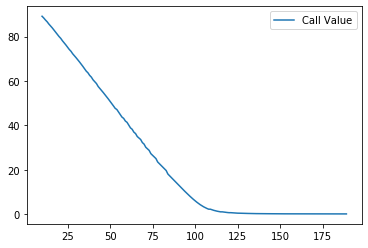

In [38]:
Spot = 100
Maturity = 1
kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014
rate = 0.02
div = 0
Strike = np.arange(10,190)


CallValues = CallHestonFFT(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, Strike)
plt.figure(1)
plt.plot(Strike, CallValues)
plt.legend(['Call Value'])
print()

In [30]:
def OptFunctionFFT(Params, Spots, Maturities, Rates, Strikes, MarketP, MarketVega):
    
    kappa = np.exp(Params[0])
    rho = np.arctanh(Params[1])
    volvol = np.exp(Params[2])
    theta = np.exp(Params[3])
    var0 = np.exp(Params[4])

    Error = np.zeros(len(Spots))
    SumDataP = 0
    
    for i in range(0, len(Spots)):
        SumDataP = SumDataP + len(Strikes[i])
        ModelRes = CallHestonFFT(Spots[i], Maturities[i], kappa, rho, volvol, theta, var0, Rates[i], 0, Strikes[i])
        Error[i] = np.sum(np.power((ModelRes - MarketP[i]), 2))
        #Error[i] = np.sum(np.power((ModelRes - MarketP[i]) / MarketVega[i], 2))    
    
    return np.sum(Error) / SumDataP

In [31]:
DataCalib = df[df.index <= pd.to_datetime('2018-01-31')].copy()

DataFilter = DataCalib.index.duplicated()
vectorBi = np.array([not y for y in DataFilter])
DataCalib2 = DataCalib[vectorBi].copy()

Strikes = []
MarketP = []
MarketVol = []
MarketVega = []

for i in range((DataCalib2.shape[0])):
    NewData = DataCalib[DataCalib.index == DataCalib2.index[i]].copy()
    Strikes.append(np.array(NewData['Strike']))
    MarketP.append(np.array(NewData['Lowest  Closing Ask Across All Exchanges']))
    MarketVol.append(np.array(NewData['Implied Volatility of the Option']))
    MarketVega.append(np.array(NewData['Vega/Kappa of the Option']))

Maturities = np.array(DataCalib2['Maturity']) / 365
Rates = np.array(DataCalib2['Rate']) / 100
Spots = np.array(DataCalib2['Spot'])

kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014

kappaY = np.log(kappa)
rhoY = np.tanh(rho)
volvolY = np.log(volvol)
thetaY = np.log(theta)
var0Y = np.log(var0)

Params0 = np.array([kappaY, rhoY, volvolY, thetaY, var0Y])
start = time.time()
#bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

result = minimize(OptFunctionFFT, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

#result = minimize(OptFunctionFFT, Params0, method="SLSQP", bounds = bnds,
#                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

end = time.time()
print(end - start)
result

31.01599884033203


 final_simplex: (array([[  8.2520621 ,  -0.62239305,   6.84117218, -15.7093381 ,
          3.43646424],
       [  7.51480464,  -0.62258317,   6.10398592, -14.59671025,
          2.69919708],
       [  6.94242403,  -0.62243538,   5.53102798, -13.73236792,
          2.126322  ],
       [  7.16010146,  -0.6225877 ,   5.74886545, -14.06217888,
          2.34430737],
       [  7.27328479,  -0.62236498,   5.8629524 , -14.22984602,
          2.45797181],
       [  7.47950059,  -0.62258703,   6.06786297, -14.543518  ,
          2.66369266]]), array([44.70330193, 44.70332438, 44.70333562, 44.70334153, 44.70334328,
       44.70336022]))
           fun: 44.70330193477231
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1000
           nit: 632
        status: 1
       success: False
             x: array([  8.2520621 ,  -0.62239305,   6.84117218, -15.7093381 ,
         3.43646424])

#### Parameter Analysis

In [32]:
def BSFormula(Spot, Vol, Strike, rate, div, Maturity, Type):
    
    d1 = (np.log(Spot/Strike) + (rate - div + 0.5 * np.power(Vol, 2)) * Maturity) / (Vol * np.power(Maturity, 0.5))
    d2 = d1 - (Vol * np.power(Maturity, 0.5))
    
    BSAux = Type * Spot * np.exp(- div * Maturity) * norm.cdf(Type * d1)
    BSValue = BSAux - Type * Strike * np.exp(- rate * Maturity) * norm.cdf(Type * d2)
    
    Vega = Spot * np.exp(-div * Maturity) * norm.pdf(d1) * np.power(Maturity, 0.5)
    
    return BSValue, Vega

In [33]:
def NewtonRaphsonV(MarketP, Strike, Type, Maturity, rate, div, Spot, InitialG, VolAccu):
    
    ImpliedVol = InitialG
    iteration = 0
    difference = VolAccu + 1
    
    while difference > VolAccu:
        LastVol = ImpliedVol
        BSValue, Vega = BSFormula(Spot, LastVol, Strike, rate, div, Maturity, Type)
        ImpliedVol = LastVol + (MarketP - BSValue) / Vega
        iteration = iteration + 1
        difference = abs(ImpliedVol - LastVol)
        if iteration > 300:
            break
    
    return ImpliedVol, iteration


# this one is not usefull but leave it here
def NewtonRaphsonP(MarketP, Strike, Type, Maturity, rate, div, Spot, InitialG, PriceAccu):
    
    ImpliedVol = InitialG
    BSValue, Vega = BSFormula(Spot, ImpliedVol, Strike, rate, div, Maturity, Type)
    iteration = 0
    
    while abs(BSValue - MarketP) > PriceAccu:
        ImpliedVol = ImpliedVol + (MarketP - BSValue) / Vega
        BSValue, Vega = BSFormula(Spot, ImpliedVol, Strike, rate, div, Maturity, Type)
        iteration = iteration + 1
        if iteration > 300:
            break
        
    return ImpliedVol, iteration


In [34]:
Spot = 100
Maturity = 1
Vol = 0.12
rate = 0.02
div = 0
Strike = 110
Type = 1

BSValue, Vega = BSFormula(Spot, Vol, Strike, rate, div, Maturity, Type)

print(BSValue)
print(Vega)

2.0070737120788387
33.95904983798885


In [35]:
Spot = 100
Maturity = 1
InitialG = 0.05
rate = 0.02
div = 0
Strike = 110
Type = 1
VolAccu = 0.00001
MarketP = 2.0070737120788387

ImpliedVol, iteration = NewtonRaphsonV(MarketP, Strike, Type, Maturity, rate, div, Spot, InitialG, VolAccu)
print(iteration)
ImpliedVol

5


0.11999999999999982

Parameter's sensitivity

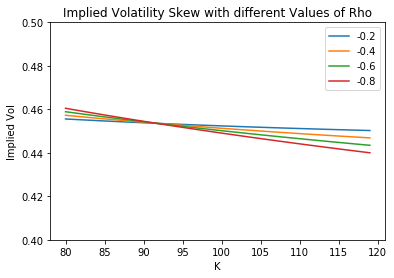

In [25]:
#Plots the Implied Volatility Smile

Spot = 100
Maturity = 1
kappa = 1.5
rho = [-.2,-.4,-.6,-.8]
volvol = 0.2
theta = 0.3
var0 = 0.12
InitialG = 0.3
rate = 0.02
div = 0
Strike = np.arange(80,120)
Type = 1
VolAccu = 0.00001

MarketP = np.zeros((40,4))
ImpliedVol = np.zeros((40,4))

for k in range(4):
    for i in range(40):
        MarketP[i,k] = CallHestonCForm(Spot, Maturity, kappa, rho[k], volvol, theta, var0, rate, div, Strike[i])
        ImpliedVol[i,k], _ = NewtonRaphsonV(MarketP[i,k], Strike[i], Type, Maturity, rate, div, Spot, InitialG, VolAccu)



plt.figure(1)
for i in range(4):
    plt.plot(Strike,ImpliedVol[:,i])
axes = plt.gca()
axes.set_ylim([.4,.5])
plt.xlabel('Strikes')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Skew with different Values of Rho')
plt.legend(['-0.2','-0.4','-0.6','-0.8'])
#plt.savefig('FFTParamRho.png')
print()

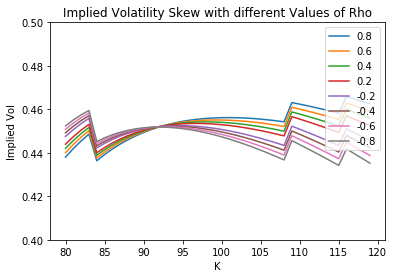

In [26]:
#Plots the Implied Volatility Smile

Spot = 100
Maturity = 1
kappa = 1.5
rho = [0.8,0.6,0.4,0.2,-0.2,-0.4,-0.6,-0.8]
volvol = 0.2
theta = 0.3
var0 = 0.12
InitialG = 0.3
rate = 0.02
div = 0
Strike = np.arange(80,120)
Type = 1
VolAccu = 0.00001

MarketP = np.zeros((40,len(rho)))
ImpliedVol = np.zeros((40,len(rho)))

for k in range(len(rho)):
    for i in range(40):
        MarketP[i,k] = CallHestonFFT(Spot, Maturity, kappa, rho[k], volvol, theta, var0, rate, div, Strike[i])
        ImpliedVol[i,k], _ = NewtonRaphsonV(MarketP[i,k], Strike[i], Type, Maturity, rate, div, Spot, InitialG, VolAccu)



plt.figure(1)
for i in range(len(rho)):
    plt.plot(Strike,ImpliedVol[:,i])
axes = plt.gca()
axes.set_ylim([.4,.5])
plt.xlabel('Strikes')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Skew with different Values of Rho')
plt.legend([0.8,0.6,0.4,0.2,-0.2,-0.4,-0.6,-0.8])
#plt.savefig('FFTParamRho.png')
print()

#### Analysis and Results

Effectiveness

Closed Form

In [36]:
Maturities = np.array(DataQ1['Maturity']) / 365
Strikes = np.array(DataQ1['Strike'])
MarketP = np.array(DataQ1['Lowest  Closing Ask Across All Exchanges'])
MarketVol = np.array(DataQ1['Implied Volatility of the Option'])
MarketVega= np.array(DataQ1['Vega/Kappa of the Option'])
Rates = np.array(DataQ1['Rate']) / 100
Spots = np.array(DataQ1['Spot'])

kappa = 1.5
rho = -0.7
volvol = 0.6
theta = 0.03
var0 = 0.014

kappaY = np.log(kappa)
rhoY = np.tanh(rho)
volvolY = np.log(volvol)
thetaY = np.log(theta)
var0Y = np.log(var0)

Params0 = np.array([kappa, rho, volvol, theta, var0])
start = time.time()

#result = minimize(OptFunctionClosedF, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
#               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

result = minimize(OptFunctionClosedF, Params0, method="SLSQP", bounds = bnds,
                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

end = time.time()
print(end - start)
result

1779.6346669197083


 final_simplex: (array([[ -1.85656273,  -0.58425759,  -0.06186638,   0.24852921,
        -20.28680557],
       [ -1.97779551,  -0.58369599,  -0.05977046,   0.36824244,
        -21.02388642],
       [ -1.79106195,  -0.58444125,  -0.06099746,   0.18412089,
        -19.89717215],
       [ -1.76737239,  -0.5854934 ,  -0.06025478,   0.16073666,
        -19.75245334],
       [ -1.71012854,  -0.58504339,  -0.05800472,   0.10603083,
        -19.42196376],
       [ -1.70443863,  -0.5846161 ,  -0.05814928,   0.09949211,
        -19.38918026]]), array([61.63649704, 61.63659667, 61.63666329, 61.63670411, 61.63696745,
       61.63697114]))
           fun: 61.63649704498242
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1001
           nit: 624
        status: 1
       success: False
             x: array([ -1.85656273,  -0.58425759,  -0.06186638,   0.24852921,
       -20.28680557])

In [40]:
DaysDataQ1 = DataQ1[np.array([not y for y in DataQ1.index.duplicated()])].copy()
#VctrDaysData = [0,5,10,15]
DaysDataQ1 = DaysDataQ1.index

In [41]:
#kappa = 7.30454353e-01
#rho = -6.67513357e-01
#volvol = 9.72802997e-01
#theta = 2.87877979e-01
#var0 = 7.27971045e-5

kappa = np.exp(-1.85656273)
rho = np.arctanh(-0.58425759)
volvol = np.exp(-0.06186638)
theta = np.exp(0.24852921)
var0 = np.exp(-20.28680557)
    
InitialG = 0.35
VolAccu = 0.00001

ModelPricDys = []
ModelVolsDys = []
MarktPricDys = []
MarktVolsDys = []
MarktStrkDys = []
SpotDys = []

for i in range(len(DaysDataQ1)):
    
    DayAnaly = DaysDataQ1[i]
    DayData = DataQ1[DataQ1.index == DayAnaly].copy()
    
    Maturities = np.array(DayData['Maturity']) / 365
    Strikes = np.array(DayData['Strike'])
    MarketP = np.array(DayData['Lowest  Closing Ask Across All Exchanges'])
    MarketVol = np.array(DayData['Implied Volatility of the Option'])
    MarketVega= np.array(DayData['Vega/Kappa of the Option'])
    Rates = np.array(DayData['Rate']) / 100
    Spots = np.array(DayData['Spot'])
    ModelPric = np.zeros(len(Spots))
    ModelImpV = np.zeros(len(Spots))
    
    for j in range(0, len(Spots)):
        ModelPric[j] = CallHestonCForm(Spots[j], Maturities[j], kappa, rho, volvol, theta, var0, Rates[j], 0, Strikes[j])
        ImpliedVol, iteration = NewtonRaphsonV(ModelPric[j], Strikes[j], 1, Maturities[j], Rates[j], 0, Spots[j], InitialG, VolAccu)
        ModelImpV[j] = ImpliedVol
    
    vectorTF = np.array([not y for y in np.isnan(ModelImpV)])
    
    ModelPricDys.append(np.array(ModelPric[vectorTF]))
    ModelVolsDys.append(np.array(ModelImpV[vectorTF]))
    MarktPricDys.append(np.array(MarketP[vectorTF]))
    MarktVolsDys.append(np.array(MarketVol[vectorTF]))
    MarktStrkDys.append(np.array(Strikes[vectorTF]))
    SpotDys.append(Spots[0])

/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


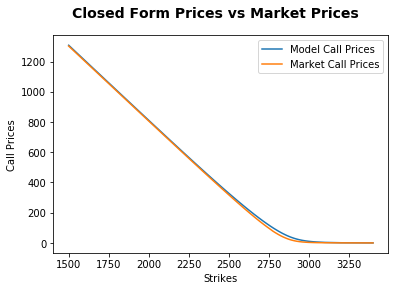

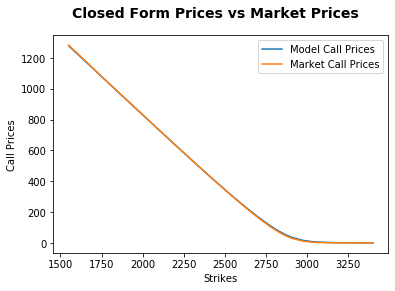

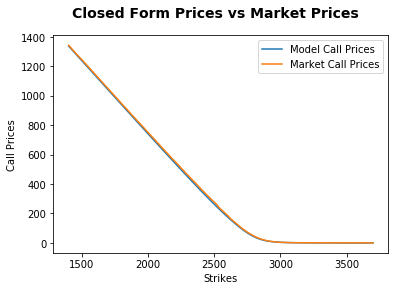

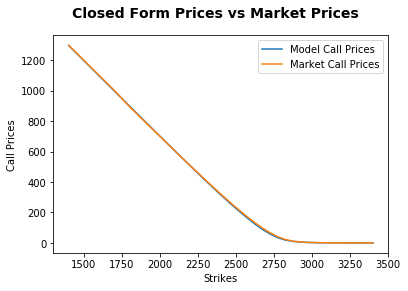

In [42]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    plt.plot(MarktStrkDys[j], ModelPricDys[j], MarktStrkDys[j], MarktPricDys[j])
    ax = fig.add_subplot(111)
    plt.legend(['Model Call Prices', 'Market Call Prices'])
    fig.suptitle('Closed Form Prices vs Market Prices', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Call Prices')
    plt.savefig('Closed Form Prices vs Market day' + str(i) + '.png')
    print()

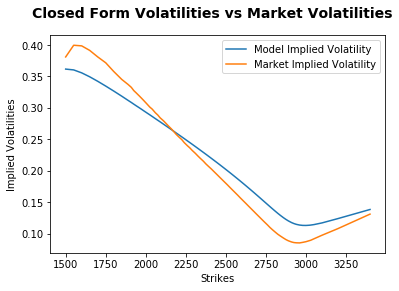

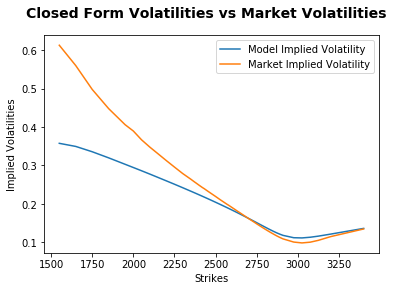

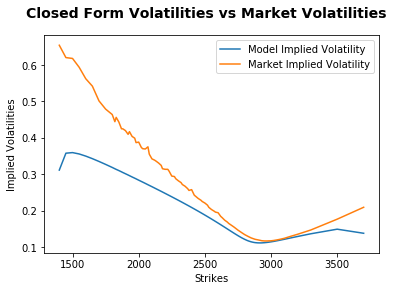

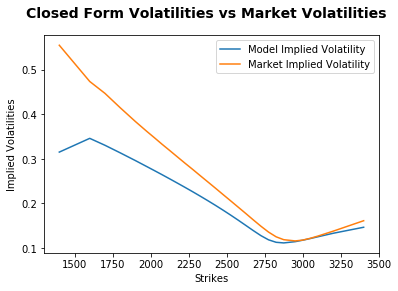

In [43]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    ax = fig.add_subplot(111)
    plt.plot(MarktStrkDys[j], ModelVolsDys[j], MarktStrkDys[j], MarktVolsDys[j])
    plt.legend(['Model Implied Volatility', 'Market Implied Volatility'])
    fig.suptitle('Closed Form Volatilities vs Market Volatilities', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatilities')
    plt.savefig('Closed Form Vol vs Market day' + str(i) + '.png')
    print()


In [44]:
PriceDifYY = []
VolatDifYY = []
PriceDifAB = []
VolatDifAB = []

for i in range(0,len(ModelPricDys)):
    PriceDif = ModelPricDys[i] - MarktPricDys[i]
    VolatDif = ModelVolsDys[i] - MarktVolsDys[i]
    PriceDifA = abs(ModelPricDys[i] - MarktPricDys[i])
    VolatDifA = abs(ModelVolsDys[i] - MarktVolsDys[i])
    idx = np.array((np.abs(np.asarray(MarktStrkDys[i]) - SpotDys[i])).argmin())
    lenvec = np.array([0, (idx/2).round().astype(int), idx, (np.array((len(MarktStrkDys[i])-idx)/2)).round().astype(int)+idx, len(ModelPricDys[i])])
    PriceDifXX = np.zeros(len(lenvec)-1)
    VolatDifXX = np.zeros(len(lenvec)-1)
    PriceDifB = np.zeros(len(lenvec)-1)
    VolatDifB = np.zeros(len(lenvec)-1)
    
    for j in range(0, len(PriceDifXX)):
        PriceDifXX[j] = np.sum(PriceDif[lenvec[j]:lenvec[j+1]])/len(PriceDif[lenvec[j]:lenvec[j+1]])
        VolatDifXX[j] = np.sum(VolatDif[lenvec[j]:lenvec[j+1]])/len(VolatDif[lenvec[j]:lenvec[j+1]])
        PriceDifB[j] = np.sum(PriceDifA[lenvec[j]:lenvec[j+1]])/len(PriceDifA[lenvec[j]:lenvec[j+1]])
        VolatDifB[j] = np.sum(VolatDifA[lenvec[j]:lenvec[j+1]])/len(VolatDifA[lenvec[j]:lenvec[j+1]])
        
    PriceDifYY.append(PriceDifXX)
    VolatDifYY.append(VolatDifXX)
    PriceDifAB.append(PriceDifB)
    VolatDifAB.append(VolatDifB)
    
PriceDifYY = np.array(PriceDifYY)
VolatDifYY = np.array(VolatDifYY)
PriceDifAB = np.array(PriceDifAB)
VolatDifAB = np.array(VolatDifAB)

In [45]:
print(np.mean(PriceDifYY, axis = 0))
print(np.mean(PriceDifAB, axis = 0))
print(np.mean(VolatDifYY, axis = 0))
print(np.mean(VolatDifAB, axis = 0))

[ 0.957201   -0.51080856  2.20868281  1.29656541]
[3.81419499 8.10932185 8.49956084 1.93034523]
[-0.05946638 -0.01606527 -0.00092448  0.00014865]
[0.0632871  0.02624153 0.01753142 0.01343101]


FFT

In [46]:
DataFilter = DataQ1.index.duplicated()
vectorBi = np.array([not y for y in DataFilter])
DataQ1Aux = DataQ1[vectorBi].copy()

Strikes = []
MarketP = []
MarketVol = []
MarketVega = []

for i in range((DataQ1Aux.shape[0])):
    NewData = DataQ1[DataQ1.index == DataQ1Aux.index[i]].copy()
    Strikes.append(np.array(NewData['Strike']))
    MarketP.append(np.array(NewData['Lowest  Closing Ask Across All Exchanges']))
    MarketVol.append(np.array(NewData['Implied Volatility of the Option']))
    MarketVega.append(np.array(NewData['Vega/Kappa of the Option']))

Maturities = np.array(DataQ1Aux['Maturity']) / 365
Rates = np.array(DataQ1Aux['Rate']) / 100
Spots = np.array(DataQ1Aux['Spot'])

kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014

Params0 = np.array([kappa, rho, volvol, theta, var0])
start = time.time()

#result = minimize(OptFunctionFFT, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
#               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

result = minimize(OptFunctionFFT, Params0, method="SLSQP", bounds = bnds,
                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))


end = time.time()
print(end - start)
result

81.93420004844666


 final_simplex: (array([[ 0.87002366, -0.62648715,  0.7493596 , -2.02628812, -4.37130095],
       [ 0.86578753, -0.62666733,  0.74811023, -2.02145648, -4.37942381],
       [ 0.86679168, -0.62646083,  0.74921855, -2.02213208, -4.37899636],
       [ 0.86155476, -0.62664228,  0.75016439, -2.01346084, -4.39468945],
       [ 0.86536206, -0.62679033,  0.74769925, -2.02184226, -4.37859607],
       [ 0.86969572, -0.62655043,  0.74864347, -2.02674423, -4.3697062 ]]), array([132.00336996, 132.00342639, 132.00344111, 132.00344858,
       132.00346913, 132.00351096]))
           fun: 132.0033699555001
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1000
           nit: 624
        status: 1
       success: False
             x: array([ 0.87002366, -0.62648715,  0.7493596 , -2.02628812, -4.37130095])

In [54]:
kappa = 7.30454353e-01
rho = -6.67513357e-01
volvol = 9.72802997e-01
theta = 2.87877979e-01
var0 = 7.27971045e-5

InitialG = 0.35
VolAccu = 0.00001

ModelPricDys = []
ModelVolsDys = []
MarktPricDys = []
MarktVolsDys = []
MarktStrkDys = []
SpotDys = []

for i in range(len(DaysDataQ1)):
    DayAnaly = DaysDataQ1[i]
    DayData = DataQ1[DataQ1.index == DayAnaly].copy()
    
    Maturities = np.array(DayData['Maturity']) / 365
    Strikes = np.array(DayData['Strike'])
    MarketP = np.array(DayData['Lowest  Closing Ask Across All Exchanges'])
    MarketVol = np.array(DayData['Implied Volatility of the Option'])
    MarketVega= np.array(DayData['Vega/Kappa of the Option'])
    Rates = np.array(DayData['Rate']) / 100
    Spots = np.array(DayData['Spot'])
    ModelImpV = np.zeros(len(Spots))
    
    ModelPric = CallHestonFFT(Spots[0], Maturities[0], kappa, rho, volvol, theta, var0, Rates[0], 0, Strikes)
    
    for j in range(0, len(ModelPric)):
        ImpliedVol, iteration = NewtonRaphsonV(ModelPric[j], Strikes[j], 1, Maturities[j], Rates[j], 0, Spots[j], InitialG, VolAccu)
        ModelImpV[j] = ImpliedVol
    
    vectorTF = np.array([not y for y in np.isnan(ModelImpV)])
    
    ModelPricDys.append(np.array(ModelPric[vectorTF]))
    ModelVolsDys.append(np.array(ModelImpV[vectorTF]))
    MarktPricDys.append(np.array(MarketP[vectorTF]))
    MarktVolsDys.append(np.array(MarketVol[vectorTF]))
    MarktStrkDys.append(np.array(Strikes[vectorTF]))
    SpotDys.append(Spots[0])

/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


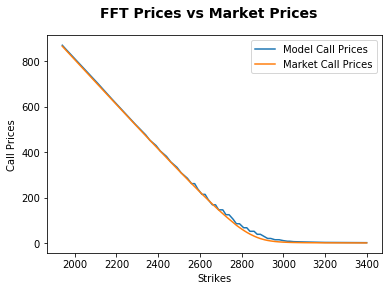

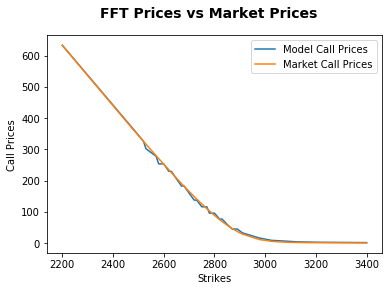

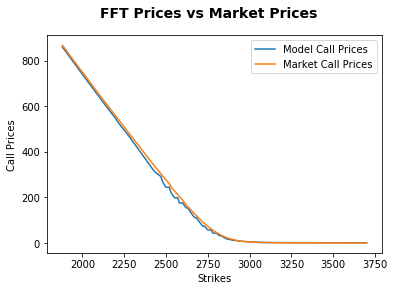

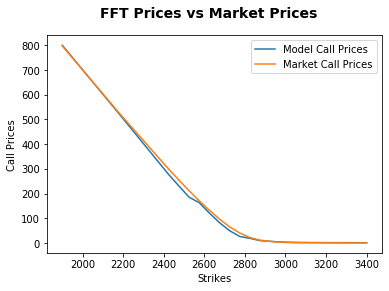

In [55]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    plt.plot(MarktStrkDys[j], ModelPricDys[j], MarktStrkDys[j], MarktPricDys[j])
    ax = fig.add_subplot(111)
    plt.legend(['Model Call Prices', 'Market Call Prices'])
    fig.suptitle('FFT Prices vs Market Prices', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Call Prices')
    plt.savefig('FFT Prices vs Market day' + str(i) + '.png')
    print()

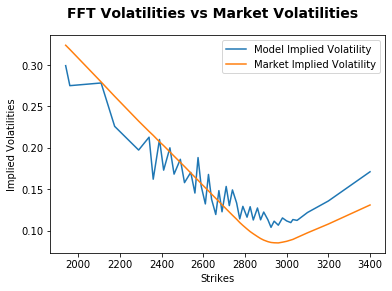

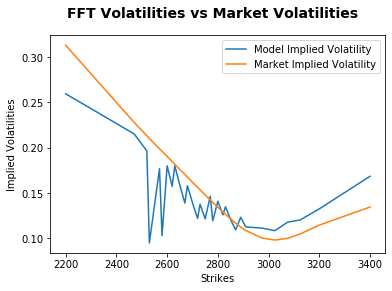

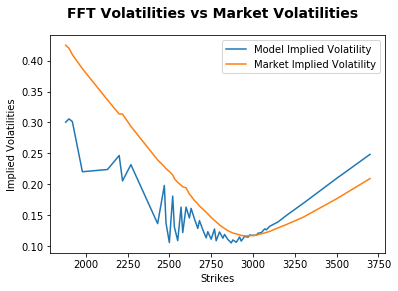

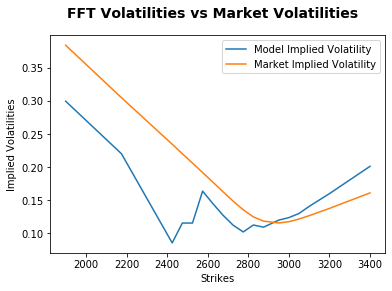

In [56]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    ax = fig.add_subplot(111)
    plt.plot(MarktStrkDys[j], ModelVolsDys[j], MarktStrkDys[j], MarktVolsDys[j])
    plt.legend(['Model Implied Volatility', 'Market Implied Volatility'])
    fig.suptitle('FFT Volatilities vs Market Volatilities', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatilities')
    plt.savefig('FFT Vol vs Market day' + str(i) + '.png')
    print()

In [104]:
PriceDifYY = []
VolatDifYY = []
PriceDifAB = []
VolatDifAB = []

for i in range(0,len(ModelPricDys)):
    PriceDif = ModelPricDys[i] - MarktPricDys[i]
    VolatDif = ModelVolsDys[i] - MarktVolsDys[i]
    PriceDifA = abs(ModelPricDys[i] - MarktPricDys[i])
    VolatDifA = abs(ModelVolsDys[i] - MarktVolsDys[i])
    idx = np.array((np.abs(np.asarray(MarktStrkDys[i]) - SpotDys[i])).argmin())
    lenvec = np.array([0, (idx/2).round().astype(int), idx, (np.array((len(MarktStrkDys[i])-idx)/2)).round().astype(int)+idx, len(ModelPricDys[i])])
    PriceDifXX = np.zeros(len(lenvec)-1)
    VolatDifXX = np.zeros(len(lenvec)-1)
    PriceDifB = np.zeros(len(lenvec)-1)
    VolatDifB = np.zeros(len(lenvec)-1)
    
    for j in range(0, len(PriceDifXX)):
        PriceDifXX[j] = np.sum(PriceDif[lenvec[j]:lenvec[j+1]])/len(PriceDif[lenvec[j]:lenvec[j+1]])
        VolatDifXX[j] = np.sum(VolatDif[lenvec[j]:lenvec[j+1]])/len(VolatDif[lenvec[j]:lenvec[j+1]])
        PriceDifB[j] = np.sum(PriceDifA[lenvec[j]:lenvec[j+1]])/len(PriceDifA[lenvec[j]:lenvec[j+1]])
        VolatDifB[j] = np.sum(VolatDifA[lenvec[j]:lenvec[j+1]])/len(VolatDifA[lenvec[j]:lenvec[j+1]])
        
    PriceDifYY.append(PriceDifXX)
    VolatDifYY.append(VolatDifXX)
    PriceDifAB.append(PriceDifB)
    VolatDifAB.append(VolatDifB)
    
PriceDifYY = np.array(PriceDifYY)
VolatDifYY = np.array(VolatDifYY)
PriceDifAB = np.array(PriceDifAB)
VolatDifAB = np.array(VolatDifAB)

In [105]:
print(np.mean(PriceDifYY, axis = 0))
print(np.mean(PriceDifAB, axis = 0))
print(np.mean(VolatDifYY, axis = 0))
print(np.mean(VolatDifAB, axis = 0))

[-6.02923129 -8.24382579 -1.07187753  1.71075119]
[ 8.96978736 12.56841047  9.08746296  1.97171601]
[-0.06631518 -0.02966594 -0.00719521  0.01425207]
[0.0697878  0.03479493 0.01955956 0.01583091]


Efficiency


In [27]:
#run pricing models based on some input params, compare speed

Spot = 100
Maturity = 1
kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014
rate = 0.02
div = 0
Strike = np.arange(10,190)

start = time.time()

for i in range(180):
    CallHestonCForm(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, Strike[i])

end = time.time()

CFtime = end - start

start2 = time.time()

for i in range(180):
    CallHestonFFT(Spot, Maturity, kappa, rho, volvol, theta, var0, rate, div, Strike[i])

end2 = time.time()

FFTtime = end2 - start2

print(CFtime,FFTtime)

0.18477296829223633 0.6351118087768555


In [ ]:
#run calibration models to get aggregated error value and speed

#initial guesses
kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014
Params0 = np.array([kappa, rho, volvol, theta, var0])

runtimes = np.zeros(15)
#Strikes = np.array(DataCalib['Strike'])
#print(len(Strikes))


for i in range(1,16):   
    DataCalib = df.iloc[:(85*i),:].copy()


    Maturities = np.array(DataCalib['Maturity']) / 365
    Strikes = np.array(DataCalib['Strike'])
    MarketP = np.array(DataCalib['Lowest  Closing Ask Across All Exchanges'])
    MarketVol = np.array(DataCalib['Implied Volatility of the Option'])
    MarketVega= np.array(DataCalib['Vega/Kappa of the Option'])
    Rates = np.array(DataCalib['Rate']) / 100
    Spots = np.array(DataCalib['Spot'])


    start = time.time()
    #result = minimize(OptFunction, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
    #               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
    bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

    result = minimize(OptFunctionClosedF, Params0, method="SLSQP", bounds = bnds,
                     args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

    end = time.time()
    runtimes[i-1] = end - start
    print(i)
    print(runtimes[i-1])
    
print(runtimes)

In [ ]:
#closed form timing plot

plt.figure(1)
plt.plot(range(1,16),runtimes)
axes = plt.gca()
plt.xlabel('Data Amount (x85 options)')
plt.ylabel('Time to Calibrate')
plt.title('Calibrate in Closed Form')
#plt.savefig('CalibrateTimeCF.png')
print()
print(sum(runtimes))

In [ ]:
#fft model calibration time analysis

kappa = 1.5
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014
Params0 = np.array([kappa, rho, volvol, theta, var0])

runtimesfft = np.zeros(15)

for i in range(1,16):
    
    DataCalib = df.iloc[:(85*i),:].copy()

    DataFilter = DataCalib.index.duplicated()
    vectorBi = np.array([not y for y in DataFilter])
    DataCalib2 = DataCalib[vectorBi].copy()

    Strikes = []
    MarketP = []
    MarketVol = []
    MarketVega = []

    for i in range((DataCalib2.shape[0])):
        NewData = DataCalib[DataCalib.index == DataCalib2.index[i]].copy()
        Strikes.append(np.array(NewData['Strike']))
        MarketP.append(np.array(NewData['Lowest  Closing Ask Across All Exchanges']))
        MarketVol.append(np.array(NewData['Implied Volatility of the Option']))
        MarketVega.append(np.array(NewData['Vega/Kappa of the Option']))

    Maturities = np.array(DataCalib2['Maturity']) / 365
    Rates = np.array(DataCalib2['Rate']) / 100
    Spots = np.array(DataCalib2['Spot'])


    
    start = time.time()
    bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

    result = minimize(OptFunctionFFT, Params0, method="SLSQP", bounds = bnds,
                     args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

    end = time.time()
    runtimesfft[i-1] = end - start
    print(i)
    print(runtimesfft[i-1])

In [ ]:
#fft timing plot

plt.figure(1)
plt.plot(range(1,16),runtimes)
axes = plt.gca()
plt.xlabel('Data Amount (x85 options)')
plt.ylabel('Time to Calibrate')
plt.title('Calibrate in FFT')
#plt.savefig('CalibrateFFT.png')
print()
print(sum(runtimes))

Comparison of Calibration Methods

In [23]:
def OptFunctionClosedFVega(Params, Spots, Maturities, Rates, Strikes, MarketP, MarketVega):
    
    kappa = Params[0]
    rho = Params[1]
    volvol = Params[2]
    theta = Params[3]
    var0 = Params[4]
    
    ModelRes = np.zeros(len(Spots))
    
    for i in range(0, len(Spots)):
        ModelRes[i] = CallHestonCForm(Spots[i], Maturities[i], kappa, rho, volvol, theta, var0, Rates[i], 0, Strikes[i])
    
    #Error = np.sum(np.power((ModelRes - MarketP), 2))
    Error = np.sum(np.power((ModelRes - MarketP) / MarketVega, 2))
    
    return Error / len(Spots)

In [24]:
Maturities = np.array(DataQ1['Maturity']) / 365
Strikes = np.array(DataQ1['Strike'])
MarketP = np.array(DataQ1['Lowest  Closing Ask Across All Exchanges'])
MarketVol = np.array(DataQ1['Implied Volatility of the Option'])
MarketVega= np.array(DataQ1['Vega/Kappa of the Option']) / 100
Rates = np.array(DataQ1['Rate']) / 100
Spots = np.array(DataQ1['Spot'])

kappa = 1.5
rho = -0.7
volvol = 0.6
theta = 0.03
var0 = 0.014

Params0 = np.array([kappa, rho, volvol, theta, var0])
start = time.time()
#result = minimize(OptFunction, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
#               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

result = minimize(OptFunctionClosedFVega, Params0, method="SLSQP", bounds = bnds,
                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))

end = time.time()
print(end - start)
result

/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true

929.7956650257111


     fun: 2255.8362238180293
     jac: array([  112.19088745, 38798.89291382,  -345.67456055,   245.71615601,
       25844.19177246])
 message: 'Positive directional derivative for linesearch'
    nfev: 492
     nit: 51
    njev: 47
  status: 8
 success: False
       x: array([ 0.59762073, -0.99993455,  0.90635956,  0.09778028,  0.0250864 ])

In [25]:
kappa = 0.59762073
rho = -0.99993455
volvol = 0.90635956
theta = 0.09778028
var0 = 0.0250864
InitialG = 0.35
VolAccu = 0.00001

ModelPricDys = []
ModelVolsDys = []
MarktPricDys = []
MarktVolsDys = []
MarktStrkDys = []
SpotDys = []

for i in range(len(DaysDataQ1)):
    
    DayAnaly = DaysDataQ1[i]
    DayData = DataQ1[DataQ1.index == DayAnaly].copy()
    
    Maturities = np.array(DayData['Maturity']) / 365
    Strikes = np.array(DayData['Strike'])
    MarketP = np.array(DayData['Lowest  Closing Ask Across All Exchanges'])
    MarketVol = np.array(DayData['Implied Volatility of the Option'])
    MarketVega= np.array(DayData['Vega/Kappa of the Option'])/100
    Rates = np.array(DayData['Rate']) / 100
    Spots = np.array(DayData['Spot'])
    ModelPric = np.zeros(len(Spots))
    ModelImpV = np.zeros(len(Spots))
    
    for j in range(0, len(Spots)):
        ModelPric[j] = CallHestonCForm(Spots[j], Maturities[j], kappa, rho, volvol, theta, var0, Rates[j], 0, Strikes[j])
        ImpliedVol, iteration = NewtonRaphsonV(ModelPric[j], Strikes[j], 1, Maturities[j], Rates[j], 0, Spots[j], InitialG, VolAccu)
        ModelImpV[j] = ImpliedVol
    
    vectorTF = np.array([not y for y in np.isnan(ModelImpV)])
    
    ModelPricDys.append(np.array(ModelPric[vectorTF]))
    ModelVolsDys.append(np.array(ModelImpV[vectorTF]))
    MarktPricDys.append(np.array(MarketP[vectorTF]))
    MarktVolsDys.append(np.array(MarketVol[vectorTF]))
    MarktStrkDys.append(np.array(Strikes[vectorTF]))
    SpotDys.append(Spots[0])

/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [26]:
kappa = 0.59762073
rho = -0.99993455
volvol = 0.90635956
theta = 0.09778028
var0 = 0.0250864
InitialG = 0.35
VolAccu = 0.00001

ModelPricDys = []
ModelVolsDys = []
MarktPricDys = []
MarktVolsDys = []
MarktStrkDys = []
SpotDys = []

for i in range(len(DaysDataQ1)):
    
    DayAnaly = DaysDataQ1[i]
    DayData = DataQ1[DataQ1.index == DayAnaly].copy()
    
    Maturities = np.array(DayData['Maturity']) / 365
    Strikes = np.array(DayData['Strike'])
    MarketP = np.array(DayData['Lowest  Closing Ask Across All Exchanges'])
    MarketVol = np.array(DayData['Implied Volatility of the Option'])
    MarketVega= np.array(DayData['Vega/Kappa of the Option'])/100
    Rates = np.array(DayData['Rate']) / 100
    Spots = np.array(DayData['Spot'])
    ModelPric = np.zeros(len(Spots))
    ModelImpV = np.zeros(len(Spots))
    
    for j in range(0, len(Spots)):
        ModelPric[j] = CallHestonCForm(Spots[j], Maturities[j], kappa, rho, volvol, theta, var0, Rates[j], 0, Strikes[j])
        ImpliedVol, iteration = NewtonRaphsonV(ModelPric[j], Strikes[j], 1, Maturities[j], Rates[j], 0, Spots[j], InitialG, VolAccu)
        ModelImpV[j] = ImpliedVol
    
    vectorTF = np.array([not y for y in np.isnan(ModelImpV)])
    
    ModelPricDys.append(np.array(ModelPric[vectorTF]))
    ModelVolsDys.append(np.array(ModelImpV[vectorTF]))
    MarktPricDys.append(np.array(MarketP[vectorTF]))
    MarktVolsDys.append(np.array(MarketVol[vectorTF]))
    MarktStrkDys.append(np.array(Strikes[vectorTF]))
    SpotDys.append(Spots[0])

/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


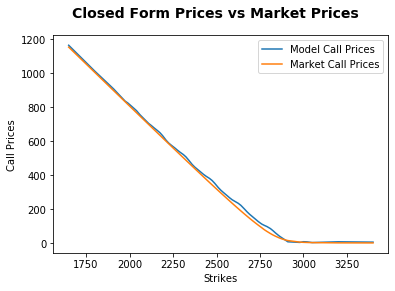

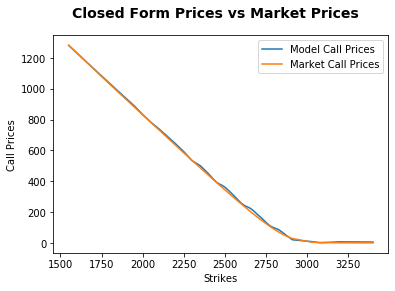

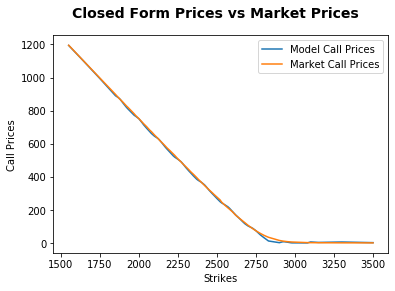

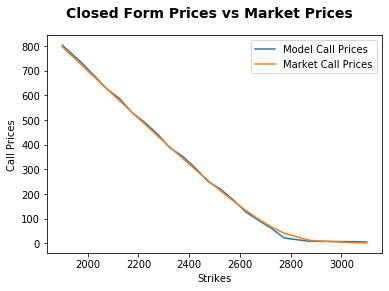

In [27]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    plt.plot(MarktStrkDys[j], ModelPricDys[j], MarktStrkDys[j], MarktPricDys[j])
    ax = fig.add_subplot(111)
    plt.legend(['Model Call Prices', 'Market Call Prices'])
    fig.suptitle('Closed Form Prices vs Market Prices', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Call Prices')
    plt.savefig('(Vega) Closed Form Prices vs Market day' + str(i) + '.png')
    print()

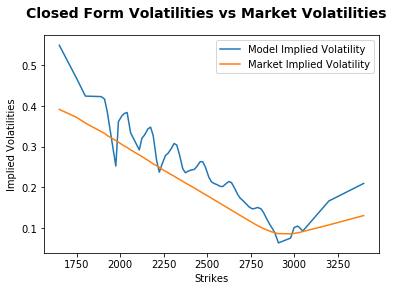

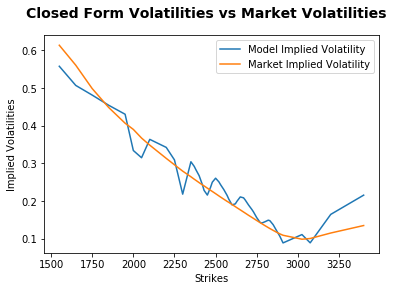

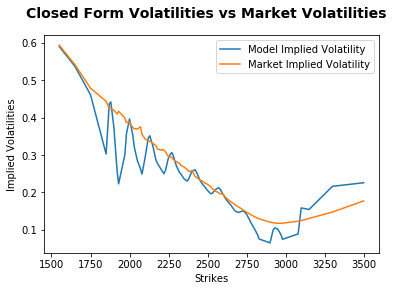

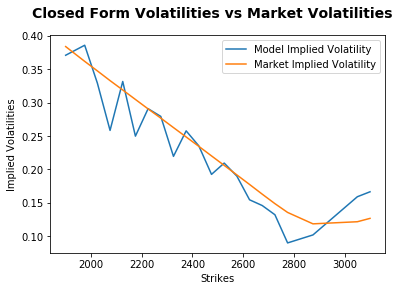

In [28]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    ax = fig.add_subplot(111)
    plt.plot(MarktStrkDys[j], ModelVolsDys[j], MarktStrkDys[j], MarktVolsDys[j])
    plt.legend(['Model Implied Volatility', 'Market Implied Volatility'])
    fig.suptitle('Closed Form Volatilities vs Market Volatilities', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatilities')
    plt.savefig('(Vega) Closed Form Vol vs Market day' + str(i) + '.png')
    print()

In [63]:
def OptFunctionFFTVega(Params, Spots, Maturities, Rates, Strikes, MarketP, MarketVega):
    
    kappa = Params[0]
    rho = Params[1]
    volvol = Params[2]
    theta = Params[3]
    var0 = Params[4]
    
    Error = np.zeros(len(Spots))
    SumDataP = 0
    
    for i in range(0, len(Spots)):
        SumDataP = SumDataP + len(Strikes[i])
        ModelRes = CallHestonFFT(Spots[i], Maturities[i], kappa, rho, volvol, theta, var0, Rates[i], 0, Strikes[i])
        #Error[i] = np.sum(np.power((ModelRes - MarketP[i]), 2))
        #print(np.power(np.array(ModelRes - MarketP[i]), 2) / np.power(MarketVega[i], 2))
        Error[i] = np.sum(np.power(np.array(ModelRes - MarketP[i]), 2) / np.power(MarketVega[i], 2))    
    
    return np.sum(Error) / SumDataP

In [65]:
DataFilter = DataQ1.index.duplicated()
vectorBi = np.array([not y for y in DataFilter])
DataQ1Aux = DataQ1[vectorBi].copy()

Strikes = []
MarketP = []
MarketVol = []
MarketVega = []

for i in range((DataQ1Aux.shape[0])):
    NewData = DataQ1[DataQ1.index == DataQ1Aux.index[i]].copy()
    Strikes.append(np.array(NewData['Strike']))
    MarketP.append(np.array(NewData['Lowest  Closing Ask Across All Exchanges']))
    MarketVol.append(np.array(NewData['Implied Volatility of the Option']))
    MarketVega.append(np.array(NewData['Vega/Kappa of the Option'] / 100)) 

Maturities = np.array(DataQ1Aux['Maturity']) / 365
Rates = np.array(DataQ1Aux['Rate']) / 100
Spots = np.array(DataQ1Aux['Spot'])

kappa = 1.6
rho = -0.4
volvol = 0.6
theta = 0.03
var0 = 0.014

Params0 = np.array([kappa, rho, volvol, theta, var0])
start = time.time()
bnds = ((0, None), (-1, 1), (0, None), (0, None), (0, None))

#result = minimize(OptFunctionFFTVega, Params0, method="SLSQP", bounds = bnds,
#                 args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega))
result = minimize(OptFunctionFFTVega, Params0, args=(Spots, Maturities, Rates, Strikes, MarketP, MarketVega), 
               method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
end = time.time()
print(end - start)
result

88.90888714790344


 final_simplex: (array([[11.88236426, -0.90694696, 11.00478868,  0.04553061, -0.49398887],
       [11.76684154, -0.90691724, 10.88661691,  0.04532752, -0.48809827],
       [11.73238807, -0.90707519, 10.85366435,  0.04518034, -0.48642683],
       [11.663868  , -0.90686703, 10.78104024,  0.04515456, -0.48283926],
       [11.47594036, -0.90693573, 10.5924776 ,  0.04468312, -0.47339679],
       [11.50346136, -0.90676969, 10.61878013,  0.04479836, -0.47473348]]), array([81155.48714634, 81164.36941167, 81168.4141313 , 81178.54108502,
       81180.7622821 , 81180.76722412]))
           fun: 81155.48714633525
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1000
           nit: 616
        status: 1
       success: False
             x: array([11.88236426, -0.90694696, 11.00478868,  0.04553061, -0.49398887])

In [66]:
kappa = 11.88236426
rho = -0.90694696
volvol = 11.00478868
theta = 0.0455306
var0 = 0
InitialG = 0.35
VolAccu = 0.00001

ModelPricDys = []
ModelVolsDys = []
MarktPricDys = []
MarktVolsDys = []
MarktStrkDys = []
SpotDys = []

for i in range(len(DaysDataQ1)):
    DayAnaly = DaysDataQ1[i]
    DayData = DataQ1[DataQ1.index == DayAnaly].copy()
    
    Maturities = np.array(DayData['Maturity']) / 365
    Strikes = np.array(DayData['Strike'])
    MarketP = np.array(DayData['Lowest  Closing Ask Across All Exchanges'])
    MarketVol = np.array(DayData['Implied Volatility of the Option'])
    MarketVega= np.array(DayData['Vega/Kappa of the Option'])/100
    Rates = np.array(DayData['Rate']) / 100
    Spots = np.array(DayData['Spot'])
    ModelImpV = np.zeros(len(Spots))
    
    ModelPric = CallHestonFFT(Spots[0], Maturities[0], kappa, rho, volvol, theta, var0, Rates[0], 0, Strikes)
    
    for j in range(0, len(ModelPric)):
        ImpliedVol, iteration = NewtonRaphsonV(ModelPric[j], Strikes[j], 1, Maturities[j], Rates[j], 0, Spots[j], InitialG, VolAccu)
        ModelImpV[j] = ImpliedVol
    
    vectorTF = np.array([not y for y in np.isnan(ModelImpV)])
    
    ModelPricDys.append(np.array(ModelPric[vectorTF]))
    ModelVolsDys.append(np.array(ModelImpV[vectorTF]))
    MarktPricDys.append(np.array(MarketP[vectorTF]))
    MarktVolsDys.append(np.array(MarketVol[vectorTF]))
    MarktStrkDys.append(np.array(Strikes[vectorTF]))
    SpotDys.append(Spots[0])

/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/cgonzalezcorssen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


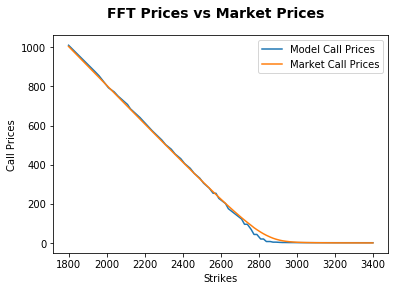

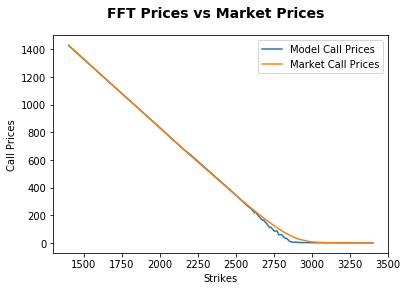

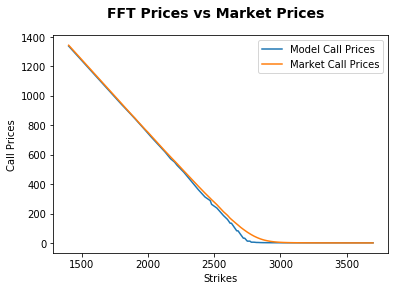

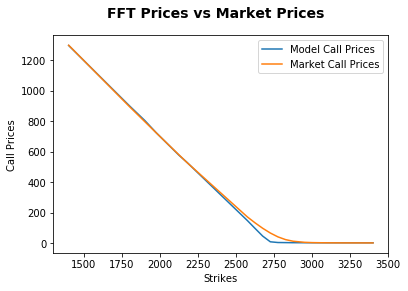

In [67]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    plt.plot(MarktStrkDys[j], ModelPricDys[j], MarktStrkDys[j], MarktPricDys[j])
    ax = fig.add_subplot(111)
    plt.legend(['Model Call Prices', 'Market Call Prices'])
    fig.suptitle('FFT Prices vs Market Prices', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Call Prices')
    plt.savefig('(Vega) FFT Prices vs Market day' + str(i) + '.png')
    print()

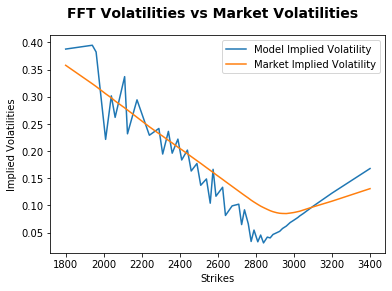

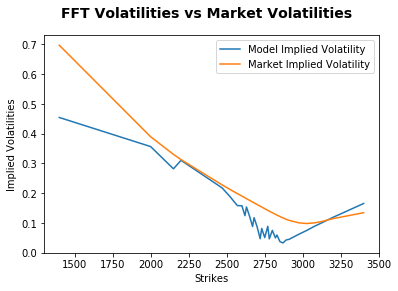

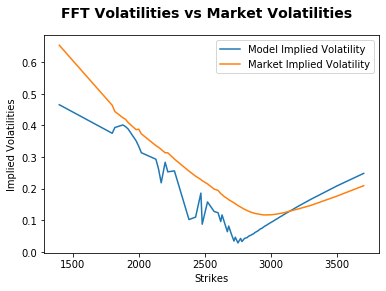

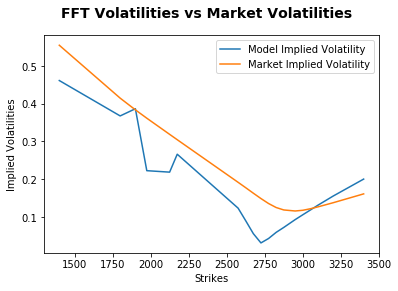

In [68]:
VctrDaysData = [1,6,11,16]
for i in range(len(VctrDaysData)):
    j = VctrDaysData[i]
    fig = plt.figure(i)
    ax = fig.add_subplot(111)
    plt.plot(MarktStrkDys[j], ModelVolsDys[j], MarktStrkDys[j], MarktVolsDys[j])
    plt.legend(['Model Implied Volatility', 'Market Implied Volatility'])
    fig.suptitle('FFT Volatilities vs Market Volatilities', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatilities')
    plt.savefig('(Vega) FFT Vol vs Market day' + str(i) + '.png')
    print()